### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# for hierarchical clusterization
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import  pdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
import os
sns.set()

In [11]:
!unzip raai_school_2024.zip

Archive:  raai_school_2024.zip
  inflating: raai_school_2024.csv    
  inflating: Задание ЛШ 2024.docx  


## Loading data

(already with anomalies)

In [2]:
data = pd.read_csv("data//raai_school_2024.csv", sep = ";")
data["payment_period"] = pd.to_datetime(data["payment_period"])
anomaly_column = pd.read_csv("data//anomaly_column.csv", sep = ";")
data["is_anomaly"] = anomaly_column["is_anomaly"].fillna(1.)
data['user_id'] = data['house_tkn'].astype(str) + '_' + data['flat_tkn'].astype(str)

a = data.groupby("flat_tkn")["house_tkn"].nunique()
data = data[~data["flat_tkn"].isin(a[a > 1].index)] # way too weird users

## Preprocessing
- удаление двух месяцев у которых мало записей
- one-hot encoding месяцев
- выделение конкретных **домов** с аномально маленькими/большими значениями по каждому из столбцов
- EIF, возможно другие методы если он окажется неадекватным

-> Результатом является data_filtered

### Artificial cutoff of the anomaly values
- for each volume take a percentile, but do not exclude NaN or 0

In [3]:
def clip_by_percentile(data, percentile = 0.95):
    numeric_features = ['income', 'debt', 'raised',
           'volume_cold', 'volume_hot', 'volume_electr']

    for feature in numeric_features:
        threshold = data[feature].quantile(percentile)
        data_filtered[feature] = data[feature].clip(upper=threshold)

    for feature in ['income', 'debt', 'raised']:
        threshold = data[feature].quantile(1-percentile)
        data_filtered[feature] = data[feature].clip(lower=min(0, threshold))

    return data

### Filling NaN values
1. Нахождение людей у которых просто нет горячей воды, заполнение таких значениями -1.
2. Отрицательные значения volume временно заполняем 0
3. Всех остальных имеет смысл заполнть медианой так как мы работаем на уровне записей

#### Filling hot water

In [4]:
# Issue is - we have various cases for hot water. It might be planned turnoff, it might be just a missed value
# it might be that user doesn't have hot water (and therefore doesn't pay).
def fill_nan_hot_water(
    data, # the table that has the nan values
    fill_value_seasonal_turnoff = 0, # value to fill users who had a planned turnoff
    fill_value_no_hot = 0, # value to fill the users who have no hot water with, naturally 0
    fill_value_forgetful_users = 0, # value to fill users who just forgot to send hot water
    add_column_seasonal = True, # whether to add column that there was a planned turnoff
    add_column_no_hot = True,
    add_columns_is_na = False
):
    data["volume_hot_na"] = data["volume_hot"].isna()

    # Filling all those who have planned turned off water
    data_updated = data.copy()
    if add_column_seasonal:
        data_updated["seasonal_turnoff"] = False
        months = data['payment_period'].map(lambda dt: dt.month)
        for month in [5,6,7]:
            is_summer_month = (months == month)

            houses_with_hot_water = data_updated.groupby("house_tkn")["volume_hot_na"].agg(lambda x: not x.all())
            houses_with_no_hot_water_in_summer = data_updated[is_summer_month].groupby("house_tkn")["volume_hot_na"].agg(lambda x: x.all())
            houses_with_seasonal_hot_water = houses_with_hot_water[houses_with_hot_water].index.intersection(
                houses_with_no_hot_water_in_summer[houses_with_no_hot_water_in_summer].index
            )

            data_with_planned_turnoff = data_updated[data_updated["house_tkn"].isin(houses_with_seasonal_hot_water)]
            data_with_planned_turnoff["volume_hot"] = data_with_planned_turnoff["volume_hot"].fillna(fill_value_seasonal_turnoff)

            data_updated = pd.concat([data_with_planned_turnoff, data_updated[~data_updated["house_tkn"].isin(data_with_planned_turnoff["house_tkn"])]])

            if add_column_seasonal:
                data_updated.loc[data_updated["house_tkn"].isin(data_with_planned_turnoff["house_tkn"]), "seasonal_turnoff"] = True

            del data_with_planned_turnoff
            del houses_with_hot_water
            del houses_with_no_hot_water_in_summer

    # Filling all those who have no hot water
    user_ids_who_have_no_hot = data_updated.groupby("user_id")["volume_hot_na"].agg(lambda x: x.all())
    users_with_no_hot = data_updated[data_updated["user_id"].isin(user_ids_who_have_no_hot[user_ids_who_have_no_hot].index)]
    users_with_no_hot["volume_hot"] = users_with_no_hot["volume_hot"].fillna(fill_value_no_hot)

    data_updated = pd.concat([users_with_no_hot, data_updated[~data["user_id"].isin(users_with_no_hot["user_id"])]])

    if add_column_no_hot:
        data_updated["no_hot_water"] = False
        data_updated.loc[data_updated["user_id"].isin(users_with_no_hot["user_id"]), "no_hot_water"] = True
    del users_with_no_hot

    # Filling the rest
    if add_columns_is_na:
        data_updated["missed_hot_water"] = data_updated["volume_hot"].isna()
    data_updated["volume_hot"] = data_updated["volume_hot"].fillna(fill_value_forgetful_users)

    data_updated.drop(columns = ["volume_hot_na"], inplace = True)
    return data_updated

In [5]:
"""
seasonal_turnoff      16918
no_hot_water        1637665
missed_hot_water     133129

seasonal_turnoff      2657
no_hot_water        214607
missed_hot_water     59828
"""

'\nseasonal_turnoff      16918\nno_hot_water        1637665\nmissed_hot_water     133129\n\nseasonal_turnoff      2657\nno_hot_water        214607\nmissed_hot_water     59828\n'

#### Clipping volumes to be >=0 (except hot water)

In [6]:
def clip_volumes(data):
    # Filling negative values with 0 (hot water as I previouslt overlooked didn't have any so we don't wanna clear previous result)
    data["volume_cold"] = data["volume_cold"].clip(lower=0)
    data["volume_electr"] = data["volume_electr"].clip(lower=0)
    return data

### Filling the rest NaN with median & scale

In [7]:
def fill_na_with_median(data):
    # Fill all the left NaNs with median
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    return imputer.fit_transform(data)

def scale_values(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    return scaler.fit_transform(data)

## Correlation

In [ ]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features].dropna()
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()
pearson = data_with_real_numeric.corr(method = 'pearson')
sns.heatmap(pearson, annot = True, fmt = ".3f")
plt.title('Pearson correlation of numerical data')

In [ ]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features].dropna()
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()
spearman = data_with_real_numeric.corr(method = 'spearman')
sns.heatmap(spearman, annot = True, fmt = ".3f")
plt.title('Spearman correlation of numerical data')

# Кластеризация данных

- если делать деревом решений то не должно возникать проблемы с NaN значениями
- если делать стандартными методам сначала надо нормализовать и разделить данные на NaN и все остальные, либо выделять тех у кого только холодная вода с целью заставить им эту воду 0, а остальных кокнуть как аномалии вручную. Некоторые стандартные методы: K-Means, DBSCAN

**До начала кластеризации** надо убрать дома и квартиры объединив их в $user\_id$. Дальше надо подумать о том каие признаки можно дабвить в табличку (например максимум, минимум, среднее, отклонение, частота выплат). Также можно пытаться учесть отдельно
1. летний период отключения горячей воды
2. отсутствие горячей воды в доме
3. периоды повышенного потребления воды, например столбца по типу +1 за зимний месяц, -1 за летний или вообще булевые (для K-means очевидно плохая идея)
4. максимальная и минимальная разница между следующим и предыдущим месяцем (имеет смысл по холодной воде чтобы исзбежать разборок с летним отключением воды)
5. среднее, стандартное отклонение ненулевых значений
6. стоимость показателей, при кластеризации имеет смысл более значимо рассматривать **raised**, **income**, **debt**. Учитывая их динамическое изменение имеет смысл их слегка модифицировать для избежания сильной корреляции

### Run first for all

In [8]:
%%time
data["month_of_admission"] = data['payment_period'].map(lambda dt: dt.month)
data_filtered = data[(data["month_of_admission"] != 10) & (data["month_of_admission"] != 12)]
data_filtered = clip_by_percentile(data_filtered)

data_filtered = fill_nan_hot_water(data,
    fill_value_seasonal_turnoff = 0,
    fill_value_no_hot = 0,
    fill_value_forgetful_users = data_filtered["volume_hot"].median(),
    add_column_seasonal = False,
    add_column_no_hot = True,
    add_columns_is_na = False
)

data_filtered = clip_volumes(data_filtered)

columns_with_na = ['volume_cold', 'volume_electr']
data_filtered.loc[:, columns_with_na] = fill_na_with_median(data_filtered[columns_with_na])
data_filtered = data_filtered[data_filtered["is_anomaly"] == 0]

C:\Users\ulyan\AppData\Local\Temp\ipykernel_3788\617446055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[feature] = data[feature].clip(upper=threshold)
C:\Users\ulyan\AppData\Local\Temp\ipykernel_3788\617446055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[feature] = data[feature].clip(upper=threshold)
C:\Users\ulyan\AppData\Local\Temp\ipykernel_3788\617446055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

CPU times: total: 1min 55s
Wall time: 2min 8s


In [11]:
data_filtered.head()

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr,is_anomaly,user_id,month_of_admission,no_hot_water,volume_water
235,2,24327,2023-01-01,68.13,0.00,26.37,2.36,0.0,123.0,0.0,2_24327,1,True,2.36
656,2,147760,2023-01-01,0.00,2578.36,1759.71,5.00,0.0,123.0,0.0,2_147760,1,True,5.00
781,2,208599,2023-01-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,1,True,5.00
782,2,208599,2023-03-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,3,True,5.00
783,2,208599,2023-04-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,4,True,5.00


In [49]:
def plot_cluster_value_distribution(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000, clusters_to_exclude = [None]):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig, axes = plt.subplots(len(plot_combinations), 1, figsize=(4, len(columns_to_plot)*4))

    # Subset for plotting (at least 20 points per class, rest random)
    plot_subset_indices = []
    cluster_list = set(range(n_clusters)) - set(clusters_to_exclude) if clusters_to_exclude is not None else set(range(n_clusters))
    for j in cluster_list:
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20 * n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    for i, x_id in enumerate(plot_combinations):
        ax = axes[i]
        ax.cla()

        histogram_data = []
        percentiles_5 = []
        percentiles_95 = []

        for j in cluster_list:
            cluster_points = subset_features[labels == j][:, x_id]

            # Calculate 5th and 95th percentiles
            percentile_5 = np.percentile(cluster_points, 5)
            percentile_95 = np.percentile(cluster_points, 95)

            # Calculate histogram data
            hist, bin_edges = np.histogram(cluster_points, bins=10, range=(percentile_5, percentile_95))
            histogram_data.append((hist, bin_edges))
            percentiles_5.append(percentile_5)
            percentiles_95.append(percentile_95)

        ax.set_xlim(min(percentiles_5), max(percentiles_95))  # Add some padding
        ax.set_ylim(0, 0.7)  # Adjust ylim

        # Plot histogram bars (using log of counts)
        for id_, j in enumerate(cluster_list):
            hist, bin_edges = histogram_data[id_]
            if len(bin_edges) == 0:
                continue
            width = (bin_edges[-1] - bin_edges[0])/10

            hist_norm = hist/(sum(hist) + 1e-6)
            print(f"cluster: {j}, size: {subset_features[labels == j][:, x_id].shape}, max bar: {max(hist_norm)*100}%")

            ax.bar(bin_edges[:-1] + width/2, hist_norm, width=width, label=f'Cluster {j}', alpha= min(0.9, max(0.4, 1-width)))

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel("Frequency")
        ax.set_title(f'Value Distribution for {columns_to_consider[x_id]}')
        ax.legend()

    plt.tight_layout()
    plt.show()

### K-Means on aggregated partly data

In [17]:
# encode month of admission to be numbers in order (without skips):
months = data_filtered.month_of_admission.unique()
months.sort()

replace_ = {"month_of_admission" : {
    month : i for month, i in zip(months, range(len(months)))
}}
data_filtered = data_filtered.replace(replace_)
data_filtered.head()

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr,is_anomaly,user_id,month_of_admission
235,2,24327,2023-01-01,68.13,0.00,26.37,2.36,0.0,123.0,0.0,2_24327,0
656,2,147760,2023-01-01,0.00,2578.36,1759.71,5.00,0.0,123.0,0.0,2_147760,0
781,2,208599,2023-01-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,0
782,2,208599,2023-03-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,2
783,2,208599,2023-04-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,3


In [33]:
grouped = data_filtered.groupby('user_id')
user_features = grouped.agg({
    'income': ['min', 'max', 'mean', 'std'],
    'debt': ['min', 'max', 'mean', 'std'],
    'raised': ['min', 'max','mean', 'std'],
    'volume_cold': ['min', 'max','mean', 'std'],
    'volume_hot': ['min', 'max','mean', 'std'],
    'volume_electr': ['min', 'max','mean', 'std'],
    'month_of_admission': ['min', 'max', 'nunique'],
})

user_features.columns = ['_'.join(col) for col in user_features.columns]

user_features['payment_delay'] = (user_features['month_of_admission_max'] - user_features['month_of_admission_min'])
user_features['payment_delay'] /= user_features['month_of_admission_nunique']  # Average delay per month

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random

random.seed(42)  # Set a fixed seed for reproducibility

def make_k_means_on_subset(columns_to_consider, subset_size=1000):
    global user_features
    user_features_to_consider = user_features[columns_to_consider].fillna(0)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(user_features_to_consider)

    random_indexes = random.sample(range(len(scaled_features)), subset_size)
    subset_features = scaled_features[random_indexes]
    n_clusters = 8

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(subset_features)

    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    return subset_features, labels, cluster_centers

In [23]:
def plot_2d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    fig, axes = plt.subplots(len(plot_combinations), len(plot_combinations), figsize=(12, 12))
    n_clusters = labels.max() + 1

    for i in range(len(plot_combinations)):
        for j in range(len(plot_combinations)):
            ax = axes[i, j]
            x_id = plot_combinations[i]
            y_id = plot_combinations[j]

            for j in range(n_clusters):
                cluster_points = subset_features[labels == j]
                ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'{j}', s=10)

            ax.scatter(cluster_centers[:, x_id], cluster_centers[:, y_id], marker='*', s=100, c='black', label='Cluster Centers')

            ax.set_xlabel(columns_to_consider[x_id])
            ax.set_ylabel(columns_to_consider[y_id])

            ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
            ax.legend()

    plt.tight_layout()

    plt.show()

In [30]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(n_clusters):
        cluster_points = subset_features[labels == i]
        ax.scatter(cluster_points[:, plot_combinations[0]],
                   cluster_points[:, plot_combinations[1]],
                   cluster_points[:, plot_combinations[2]], label=f'Cluster {i}')

    ax.scatter(cluster_centers[:, plot_combinations[0]],
               cluster_centers[:, plot_combinations[1]],
               cluster_centers[:, plot_combinations[2]], marker='*', s=200, c='black', label='Cluster Centers')

    ax.set_xlabel(columns_to_consider[plot_combinations[0]])
    ax.set_ylabel(columns_to_consider[plot_combinations[1]])
    ax.set_zlabel(columns_to_consider[plot_combinations[2]])

    ax.legend()
    plt.show()

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
%matplotlib nbagg

def plot_3d_kmeans_results_rotating(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers, plot_vertices_number=1000):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    scatters = []
    for i in range(n_clusters):
        scatters.append(ax.scatter([], [], [], label=f'Cluster {i}'))
    center_scatter = ax.scatter([], [], [], marker='*', s=200, c='black', label='Cluster Centers')

    ax.set_xlabel(columns_to_consider[plot_combinations[0]])
    ax.set_ylabel(columns_to_consider[plot_combinations[1]])
    ax.set_zlabel(columns_to_consider[plot_combinations[2]])
    ax.legend()

    plot_subset_features = []
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_features.extend(random.sample(list(cluster_indices), 20))
    plot_subset_features.extend(random.sample(subset_features, plot_vertices_number - 20*n_clusters))
    plot_subset_features = np.array(plot_subset_features)

    def animate(i):
        #ax.cla()
        for j in range(n_clusters):
            cluster_points = plot_subset_features[labels == j]
            scatters[j]._offsets3d = (cluster_points[:, plot_combinations[0]],
                                     cluster_points[:, plot_combinations[1]],
                                     cluster_points[:, plot_combinations[2]])

        center_scatter._offsets3d = (cluster_centers[:, plot_combinations[0]],
                                    cluster_centers[:, plot_combinations[1]],
                                    cluster_centers[:, plot_combinations[2]])

        ax.view_init(30, i)  # Adjust view angles as needed
        return scatters + [center_scatter]

    ani = FuncAnimation(fig, animate, frames=360, interval=20, blit=True)
    ani.save('simulation.mp4', dpi=150, fps=30, writer='ffmpeg', extra_args=['-vcodec', 'libx264'])

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


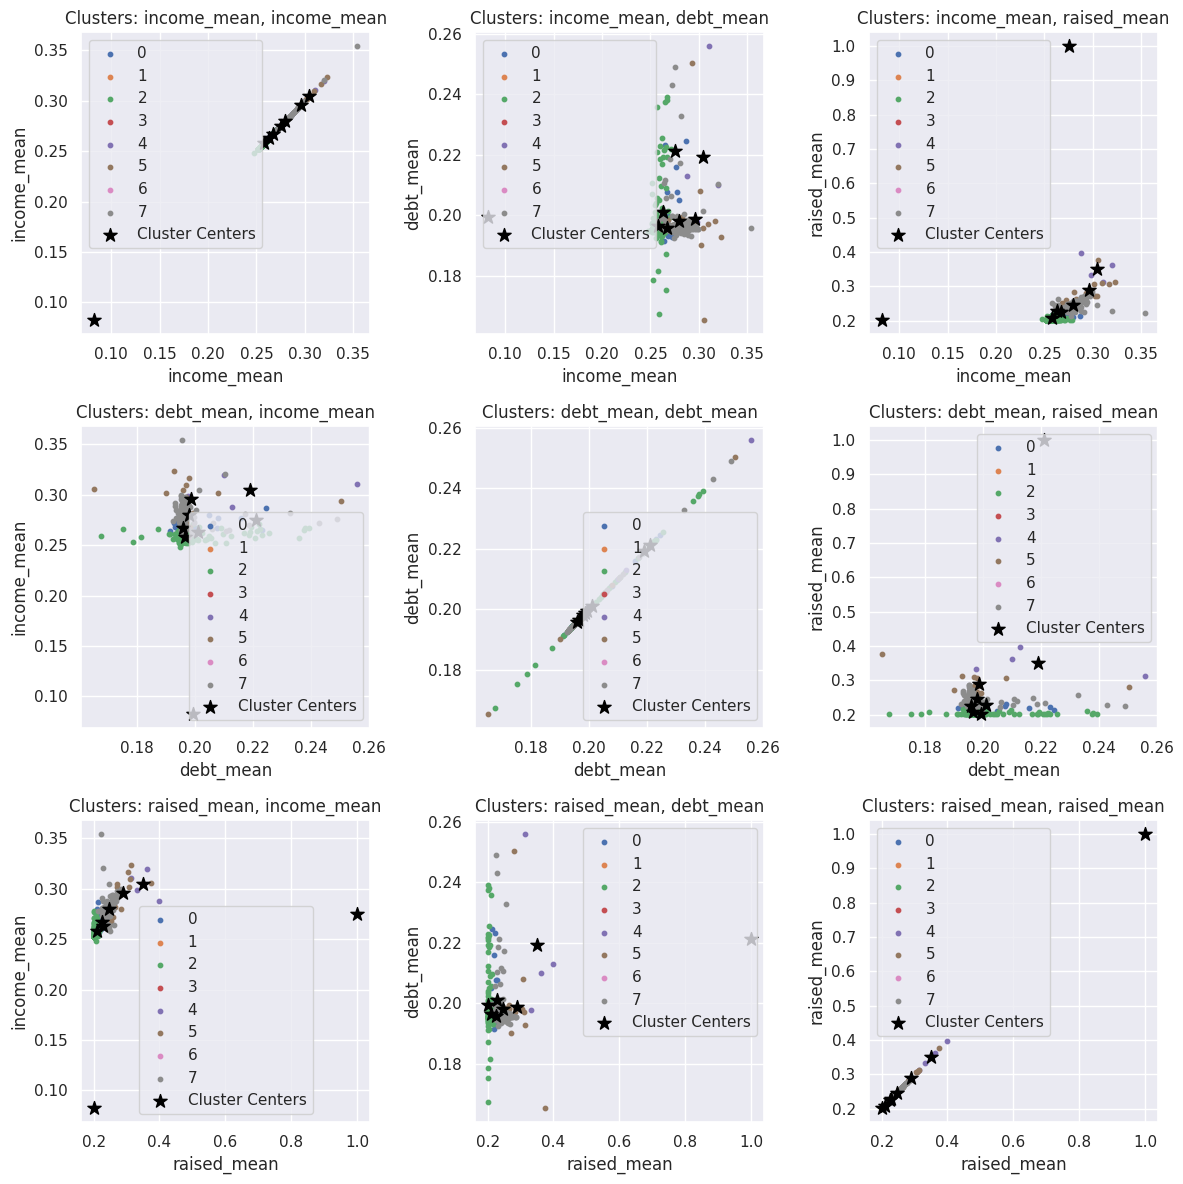

In [29]:
columns_to_consider = ["income_min", "income_max", "income_mean", "income_std",
                       "debt_min", "debt_max", "debt_mean", "debt_std",
                       "raised_min", "raised_max", "raised_mean", "raised_std"]
subset_features, labels, cluster_centers = make_k_means_on_subset(columns_to_consider)

columns_to_plot = ["income_mean", "debt_mean", "raised_mean"]
plot_2d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)

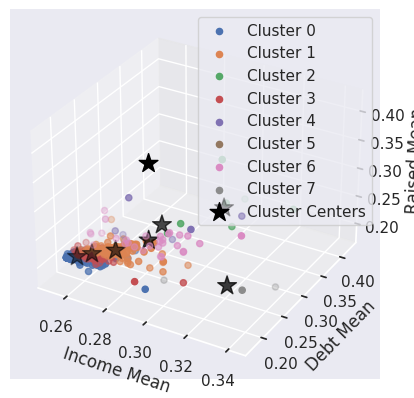

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


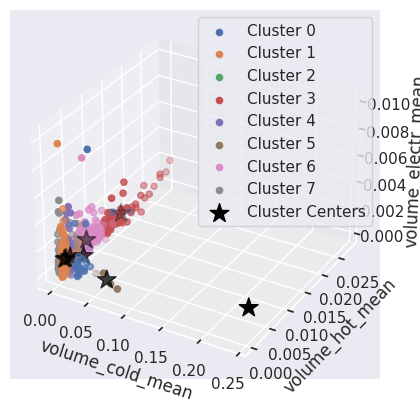

In [34]:
columns_to_consider = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean"]

subset_features, labels, cluster_centers = make_k_means_on_subset(columns_to_consider)

columns_to_plot = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean"]
plot_3d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)

In [46]:
columns_to_consider = ["volume_cold_max", "volume_cold_mean",
                       "volume_hot_max", "volume_hot_mean",
                       "volume_electr_max", "volume_electr_mean"]

subset_features, labels, cluster_centers = make_k_means_on_subset(columns_to_consider)

columns_to_plot = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean"]
plot_3d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<IPython.core.display.Javascript object>

In [43]:
plot_3d_kmeans_results_rotating(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)

<IPython.core.display.Javascript object>

D:\E\Downloads\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


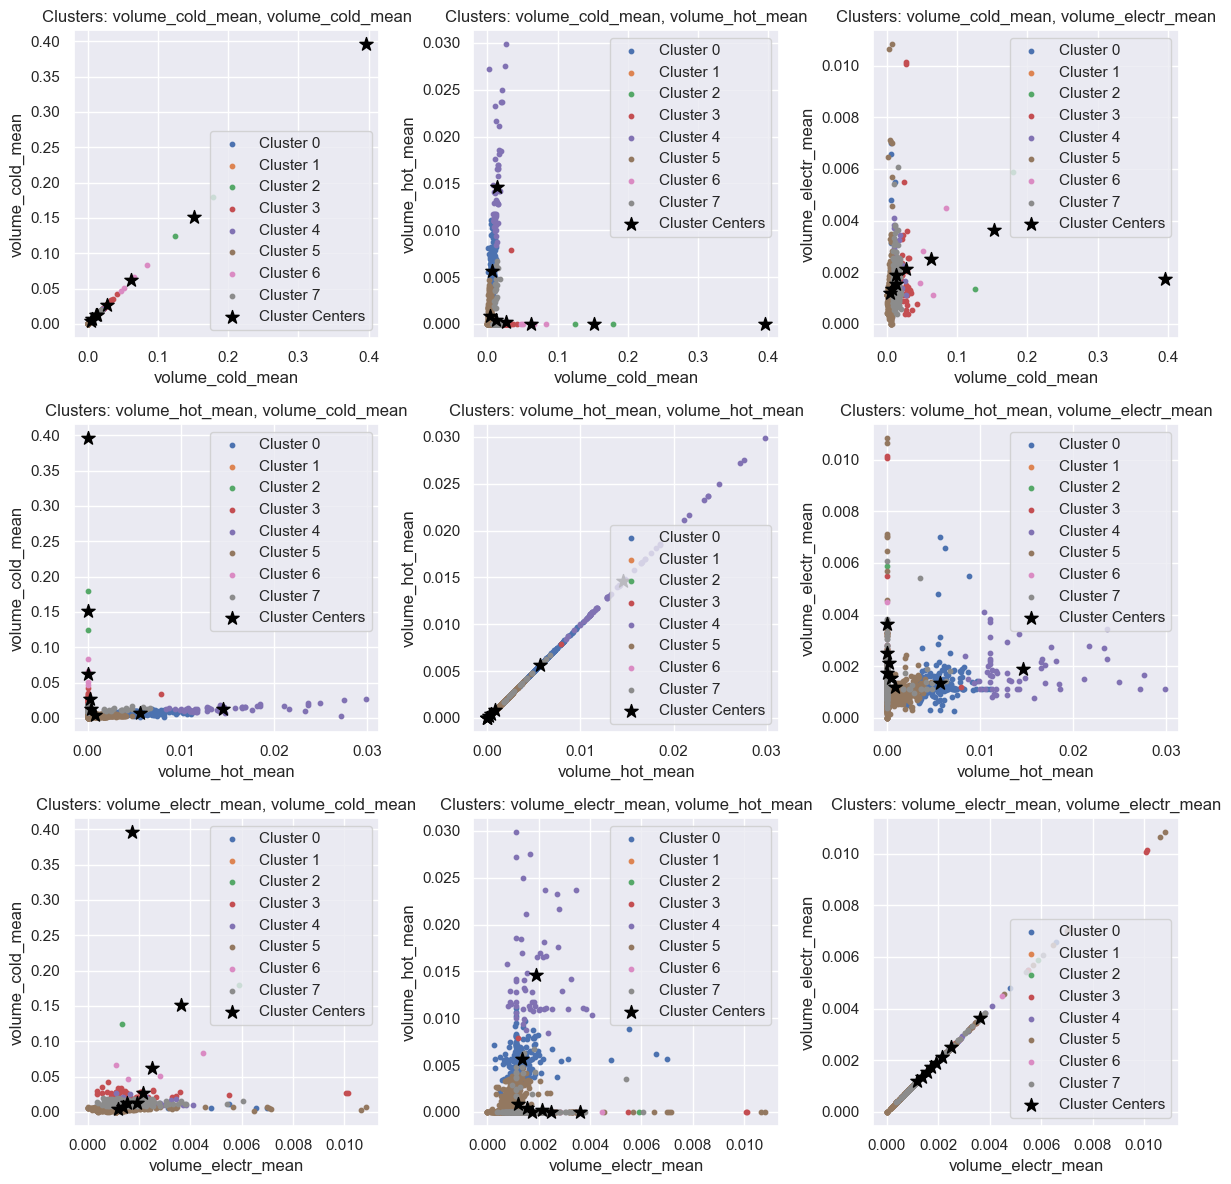

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

columns_to_consider = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean",]

user_features = user_features[columns_to_consider].fillna(0)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(user_features)

subset_features = scaled_features[:1000]
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(subset_features)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plot_combinations = [
   0, 1, 2
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(len(plot_combinations)):
    for j in range(len(plot_combinations)):
        ax = axes[i, j]  # Position in the grid
        x_id = plot_combinations[i]
        y_id = plot_combinations[j]

        # Plot clusters for each combination
        for j in range(n_clusters):  # Adjust for the number of clusters
            cluster_points = subset_features[labels == j]
            ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'Cluster {j}', s=10)

        ax.scatter(cluster_centers[:, x_id], cluster_centers[:, y_id], marker='*', s=100, c='black', label='Cluster Centers')

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel(columns_to_consider[y_id])

        ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
        ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

## Hieararchical clustering

### Run first

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import time as time
import random

random.seed(42)

grouped = data_filtered.groupby('user_id')
user_features = grouped.agg({
    'income': ['min', 'max', 'mean', 'std'],
    'debt': ['min', 'max', 'mean', 'std'],
    'raised': ['min', 'max','mean', 'std'],
    'volume_cold': ['min', 'max','mean', 'std'],
    'volume_hot': ['min', 'max','mean', 'std'],
    'volume_electr': ['min', 'max','mean', 'std'],
    'month_of_admission': ['min', 'max', 'nunique'],
})

user_features.columns = ['_'.join(col) for col in user_features.columns]

user_features['payment_delay'] = (user_features['month_of_admission_max'] - user_features['month_of_admission_min'])
user_features['payment_delay'] /= user_features['month_of_admission_nunique']  # Average delay per month

In [24]:
def plot_2d_results(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    fig, axes = plt.subplots(len(plot_combinations), len(plot_combinations), figsize=(12, 12))
    n_clusters = labels.max() + 1

    plot_subset_indices = []
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20*n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    for i in range(len(plot_combinations)):
        for j in range(len(plot_combinations)):
            ax = axes[i, j]
            x_id = plot_combinations[i]
            y_id = plot_combinations[j]

            for j in range(n_clusters):
                cluster_points = subset_features[labels == j]
                ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'{j}', s=10)

            ax.set_xlabel(columns_to_consider[x_id])
            ax.set_ylabel(columns_to_consider[y_id])

            ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
            ax.legend()

    plt.tight_layout()

    plt.show()

In [25]:
def plot_3d_results(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000):
    plot_subset_indices = []
    n_clusters = labels.max() + 1
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20*n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
    ax1.set_position([0, 0, 0.95, 1])
    for l in np.unique(labels):
        ax1.scatter(
            subset_features[labels == l, 0],
            subset_features[labels == l, 1],
            subset_features[labels == l, 2],
            color=plt.cm.jet(float(l) / np.max(labels + 1)),
            s=20,
            edgecolor="k",
        )
    _ = fig1.suptitle(f"Without connectivity constraints (time {elapsed_time:.2f}s)")
    plt.show()

In [26]:
def run_ward(columns_to_consider, n_clusters=8, subset_size = 10000):
    global user_features
    X = user_features[columns_to_consider]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    random_indexes = random.sample(range(len(X)), subset_size)
    X = X[random_indexes]

    print("Compute unstructured hierarchical clustering...")
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(X)
    elapsed_time = time.time() - st
    label = ward.labels_
    print(f"Elapsed time: {elapsed_time:.2f}s")
    print(f"Number of points: {label.size}")
    return X, label, scaler

### Experiments

Compute unstructured hierarchical clustering...
Elapsed time: 11.42s
Number of points: 10000


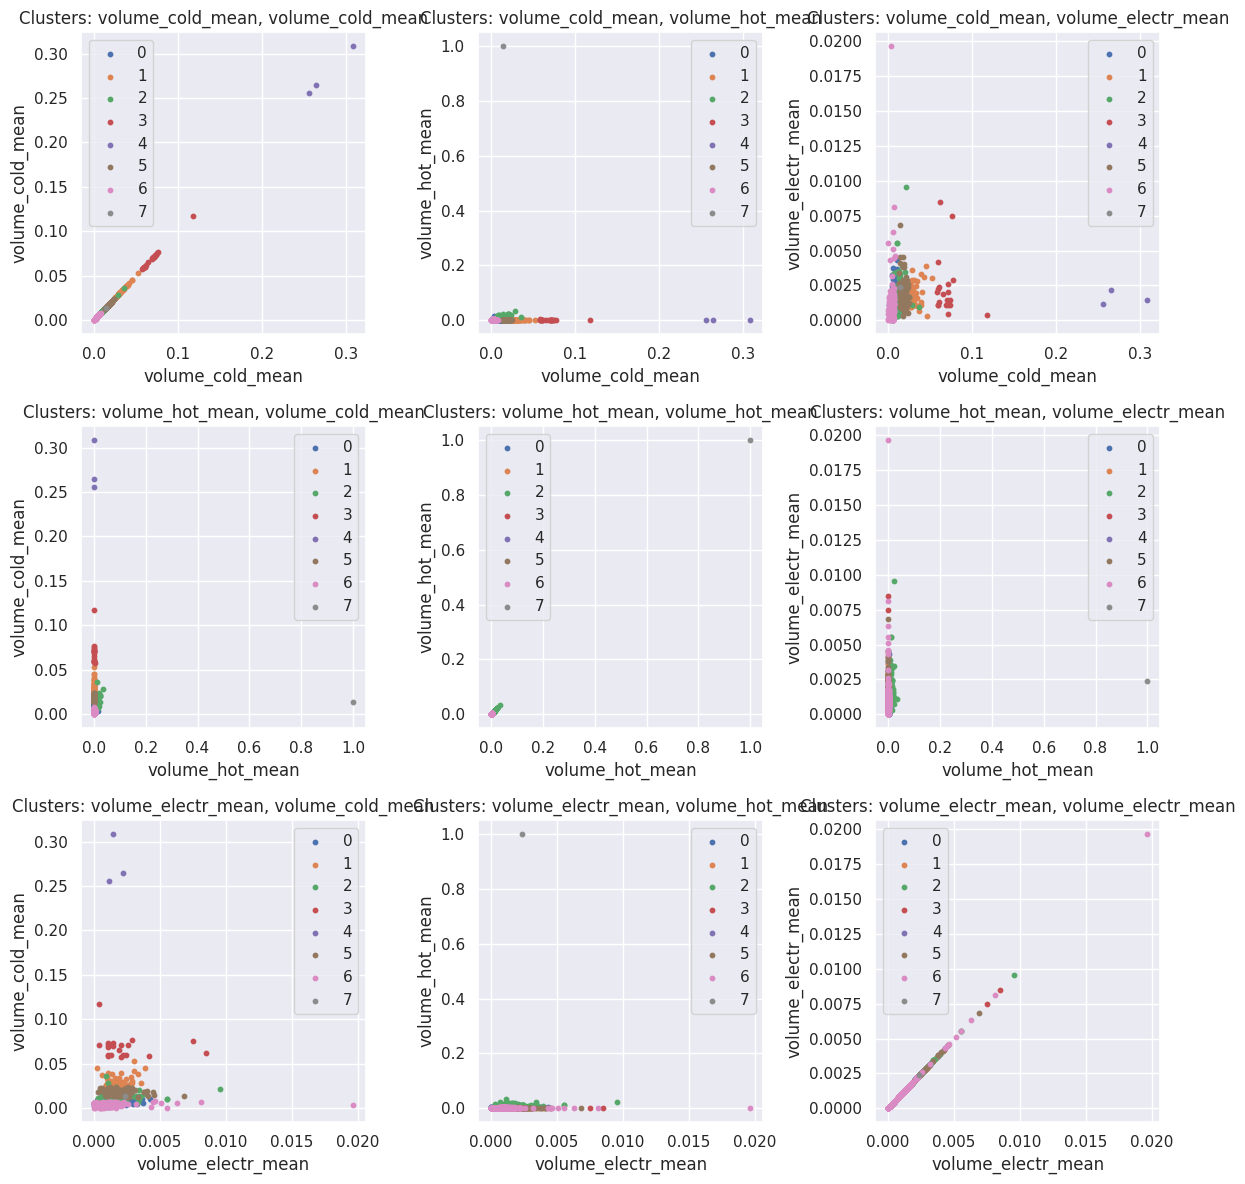

In [51]:
columns_to_consider = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
X, label, _ = run_ward(columns_to_consider, n_clusters = 8, subset_size = 10000)

columns_to_plot = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
plot_2d_results(columns_to_consider, columns_to_plot, X, label)

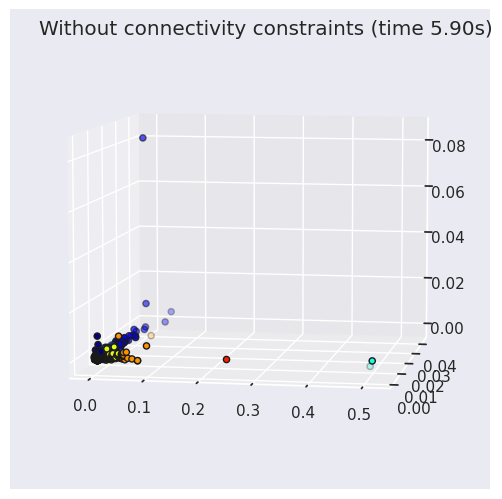

In [47]:
plot_3d_results(columns_to_consider, columns_to_plot, X, label, plot_vertices_number=1000)

In [ ]:
# Experiment 2: 4 clusters

Compute unstructured hierarchical clustering...
Elapsed time: 7.25s
Number of points: 10000


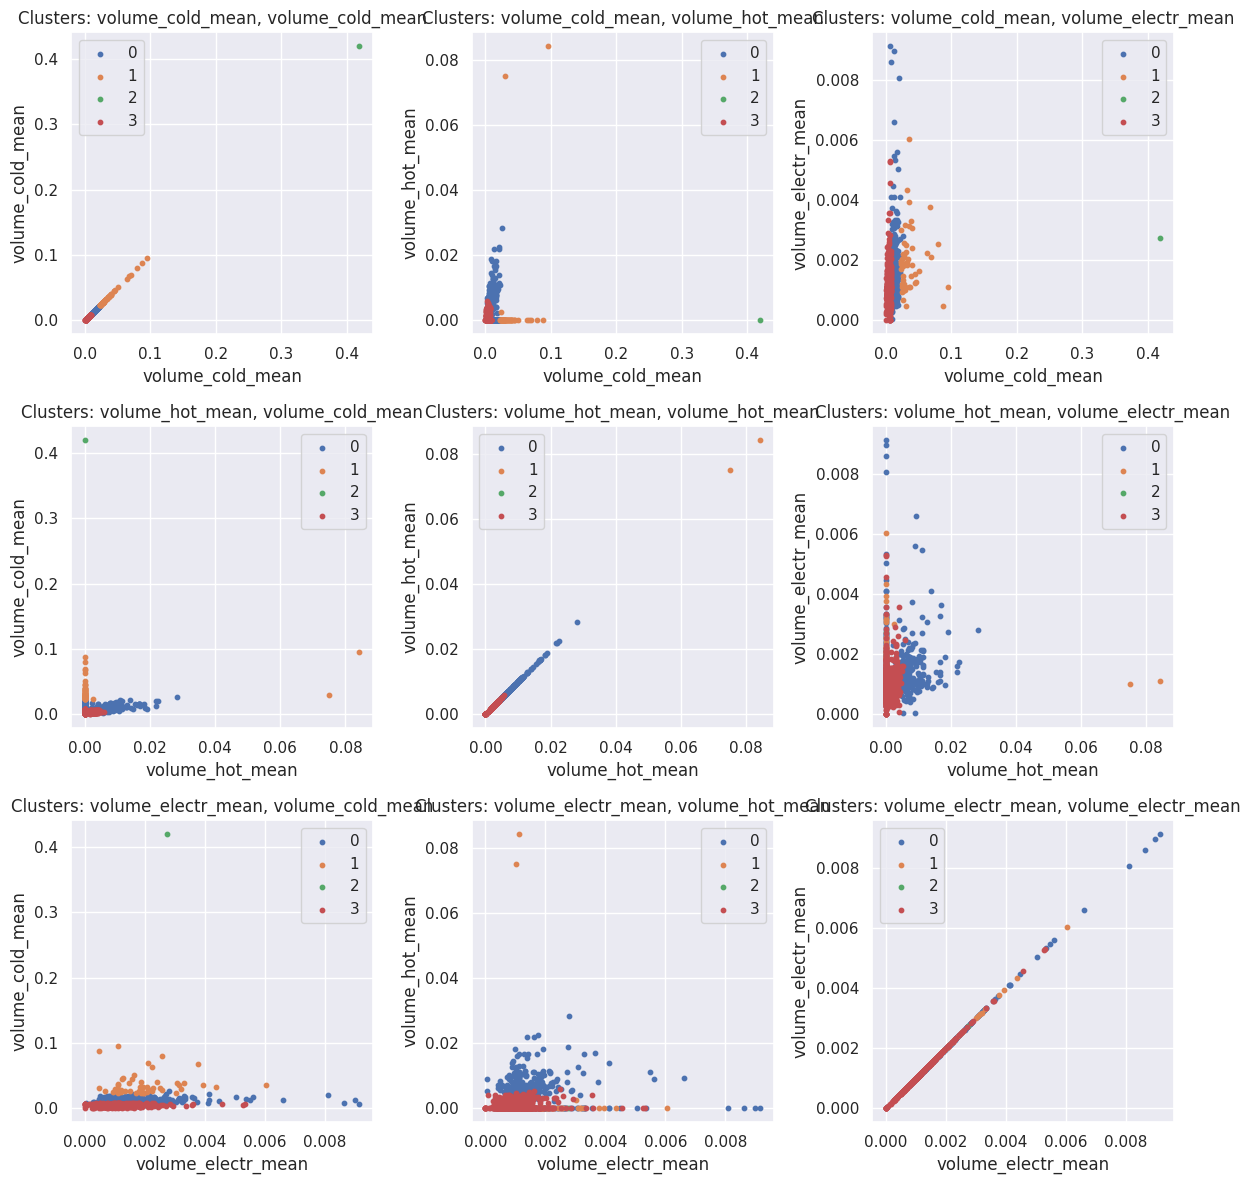

In [53]:
columns_to_consider = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
X, label, _ = run_ward(columns_to_consider, n_clusters = 4, subset_size = 10000)

columns_to_plot = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
plot_2d_results(columns_to_consider, columns_to_plot, X, label)

Compute unstructured hierarchical clustering...
Elapsed time: 6.68s
Number of points: 10000


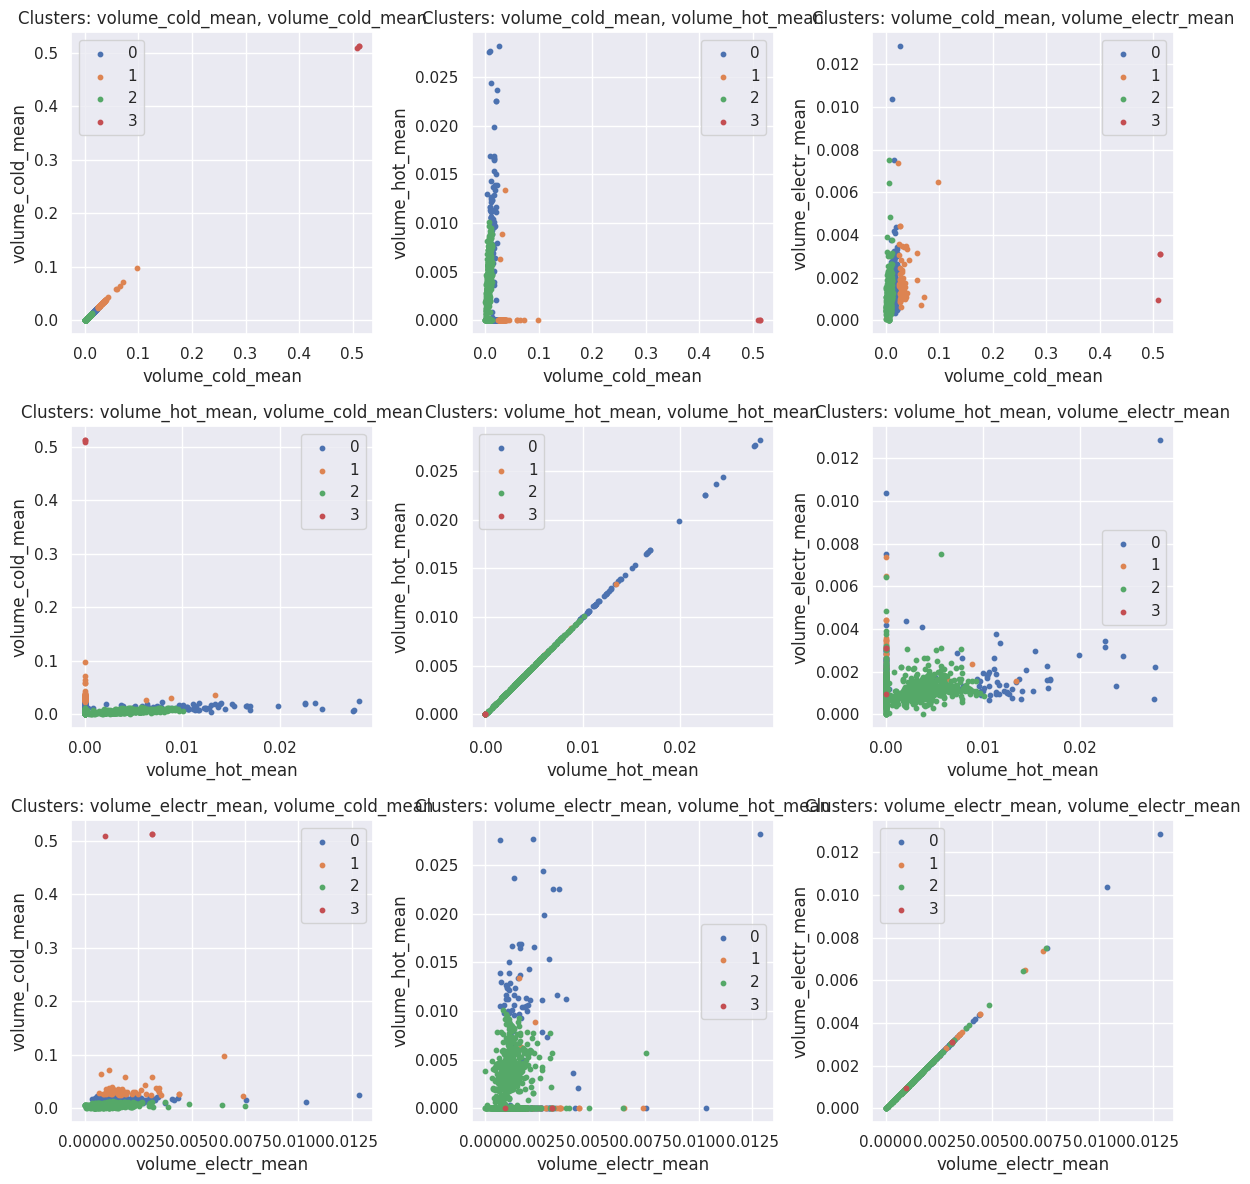

AttributeError: Rectangle.set() got an unexpected keyword argument 'rwidthfloat'

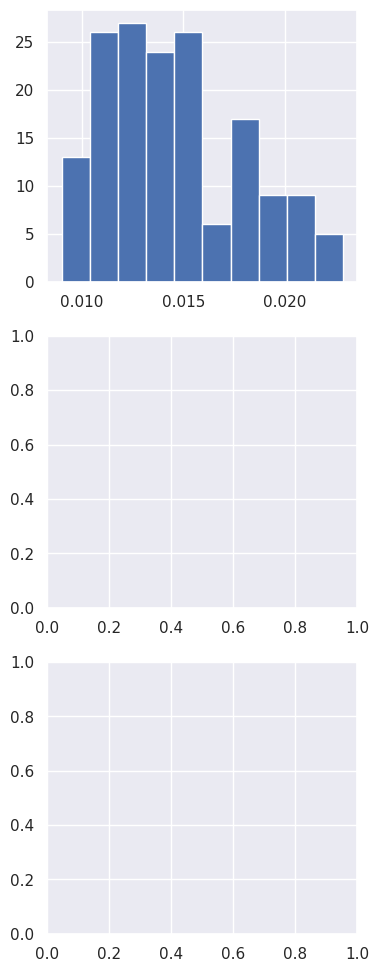

In [29]:
columns_to_consider = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
X, label, _ = run_ward(columns_to_consider, n_clusters = 4, subset_size = 10000)

columns_to_plot = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
plot_2d_results(columns_to_consider, columns_to_plot, X, label)

cluster: 0, size: (190,), max bar: 18.60465105462412%
cluster: 1, size: (55,), max bar: 22.448979133694305%
cluster: 2, size: (735,), max bar: 16.6163141742956%
cluster: 0, size: (190,), max bar: 66.11111074382717%
cluster: 1, size: (55,), max bar: 99.99999807692312%
cluster: 2, size: (735,), max bar: 46.848137468698944%
cluster: 0, size: (190,), max bar: 23.529411626297577%
cluster: 1, size: (55,), max bar: 32.653060558100805%
cluster: 2, size: (735,), max bar: 29.652042315201143%


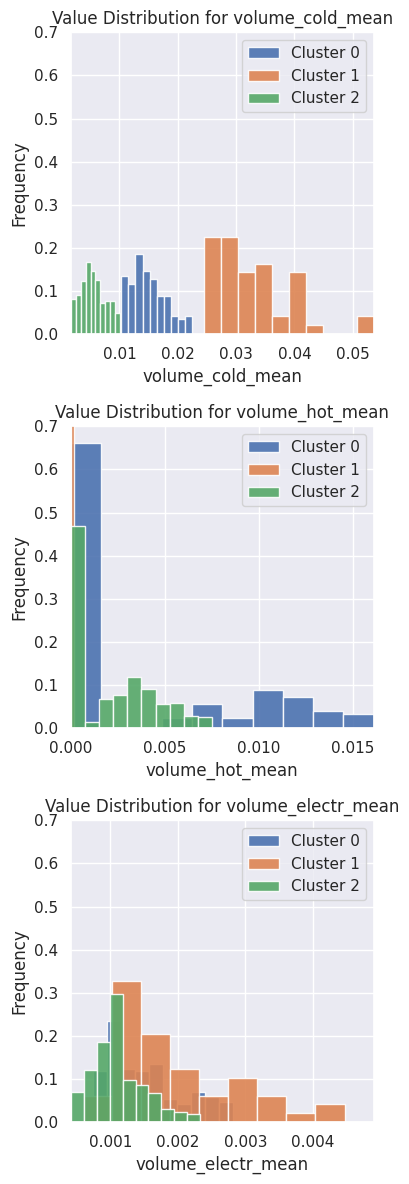

In [74]:
def plot_cluster_value_distribution(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000, clusters_to_exclude = [None]):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig, axes = plt.subplots(len(plot_combinations), 1, figsize=(4, len(columns_to_plot)*4))

    # Subset for plotting (at least 20 points per class, rest random)
    plot_subset_indices = []
    cluster_list = set(range(n_clusters)) - set(clusters_to_exclude) if clusters_to_exclude is not None else set(range(n_clusters))
    for j in cluster_list:
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20 * n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    for i, x_id in enumerate(plot_combinations):
        ax = axes[i]
        ax.cla()

        histogram_data = []
        percentiles_5 = []
        percentiles_95 = []

        for j in cluster_list:
            cluster_points = subset_features[labels == j][:, x_id]

            # Calculate 5th and 95th percentiles
            percentile_5 = np.percentile(cluster_points, 5)
            percentile_95 = np.percentile(cluster_points, 95)

            # Calculate histogram data
            hist, bin_edges = np.histogram(cluster_points, bins=10, range=(percentile_5, percentile_95))
            histogram_data.append((hist, bin_edges))
            percentiles_5.append(percentile_5)
            percentiles_95.append(percentile_95)

        ax.set_xlim(min(percentiles_5), max(percentiles_95))  # Add some padding
        ax.set_ylim(0, 0.7)  # Adjust ylim

        # Plot histogram bars (using log of counts)
        for j in cluster_list:
            hist, bin_edges = histogram_data[j]
            width = (bin_edges[-1] - bin_edges[0])/10

            hist_norm = hist/(sum(hist) + 1e-6)
            print(f"cluster: {j}, size: {subset_features[labels == j][:, x_id].shape}, max bar: {max(hist_norm)*100}%")

            ax.bar(bin_edges[:-1] + width/2, hist_norm, width=width, label=f'Cluster {j}', alpha= min(0.9, max(0.4, 1-width)))

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel("Frequency")
        ax.set_title(f'Value Distribution for {columns_to_consider[x_id]}')
        ax.legend()

    plt.tight_layout()
    plt.show()
plot_cluster_value_distribution(columns_to_consider, columns_to_plot, X, label, clusters_to_exclude=[3])

## AgglomerativeClustering

### Run first

In [12]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import time as time
import random

random.seed(42)

data_filtered["volume_water"] = data_filtered["volume_cold"] + data_filtered["volume_hot"]
grouped = data_filtered.groupby('flat_tkn')
user_features = grouped.agg({
    'income': ['min', 'max', 'mean', 'std'],
    'debt': ['min', 'max', 'mean', 'std'],
    'raised': ['min', 'max','mean', 'std'],
    'volume_cold': ['min', 'max','mean', 'std'],
    'volume_hot': ['min', 'max','mean', 'std'],
    'volume_water': ['min', 'max','mean', 'std'],
    'volume_electr': ['min', 'max','mean', 'std'],
    'month_of_admission': ['min', 'max', 'nunique'],
})

user_features.columns = ['_'.join(col) for col in user_features.columns]

user_features['payment_delay'] = (user_features['month_of_admission_max'] - user_features['month_of_admission_min'])

for value in ["income", "debt", "raised", "volume_cold", "volume_hot", "volume_electr"]:
    user_features[f"{value}_mean"] /= user_features['month_of_admission_nunique'] / user_features['payment_delay']

user_features['payment_delay'] /= user_features['month_of_admission_nunique']  # Average delay per month

In [10]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [11]:
def run_ward(columns_to_consider, distance_threshold=None, n_clusters=None, subset_size = 10000):
    global user_features
    X = user_features[columns_to_consider]
    X = fill_na_with_median(X)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    random_indexes = random.sample(range(len(X)), subset_size)
    X = X[random_indexes]

    print("Compute unstructured hierarchical clustering...")
    st = time.time()
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters, linkage="ward").fit(X)
    elapsed_time = time.time() - st
    print(f"Elapsed time: {elapsed_time:.2f}s")
    print(f"Number of points: {model.labels_.size}")
    print(f"Number of clusters: {model.labels_.max()+1}")
    return X, model, scaler

In [22]:
random.seed(42)

def get_x(columns_to_consider,  subset_size = 10000):
    global user_features
    X = user_features[columns_to_consider]
    X = fill_na_with_median(X)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

### Experiments

#### Experiment 1

Compute unstructured hierarchical clustering...
Elapsed time: 7.85s
Number of points: 10000
Number of clusters: 8


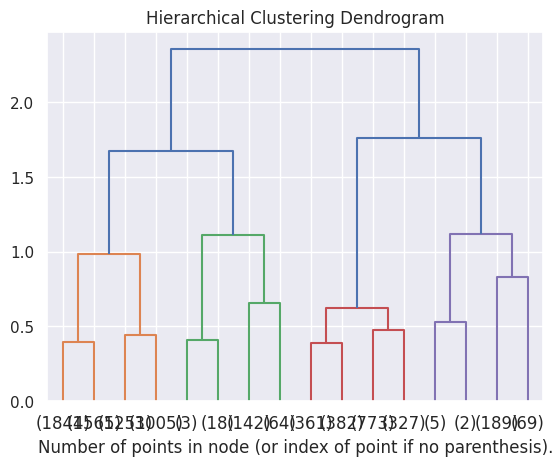

In [89]:
columns_to_consider = [f"{i}_{j}" for i in ['debt', 'raised'] for j in ['min', 'max','mean', 'std']]
X, model, _ = run_ward(columns_to_consider, distance_threshold=0.8, n_clusters=None, subset_size = 10000)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

cluster: 0, size: (40,), max bar: 30.55555470679015%
cluster: 1, size: (7,), max bar: 39.9999920000016%
cluster: 2, size: (173,), max bar: 35.483870738813735%
cluster: 3, size: (377,), max bar: 43.65781698036042%
cluster: 4, size: (22,), max bar: 33.33333148148158%
cluster: 5, size: (22,), max bar: 31.578945706371275%
cluster: 6, size: (315,), max bar: 39.929328480815094%
cluster: 7, size: (31,), max bar: 33.33333209876548%
cluster: 0, size: (40,), max bar: 57.8947353185596%
cluster: 1, size: (7,), max bar: 39.9999920000016%
cluster: 2, size: (173,), max bar: 21.935483729448492%
cluster: 3, size: (377,), max bar: 17.597765313972722%
cluster: 4, size: (22,), max bar: 16.66666574074079%
cluster: 5, size: (22,), max bar: 59.99999700000015%
cluster: 6, size: (315,), max bar: 16.961130682116146%
cluster: 7, size: (31,), max bar: 18.51851783264749%
cluster: 0, size: (40,), max bar: 27.77777700617286%
cluster: 1, size: (7,), max bar: 39.9999920000016%
cluster: 2, size: (173,), max bar: 35.483

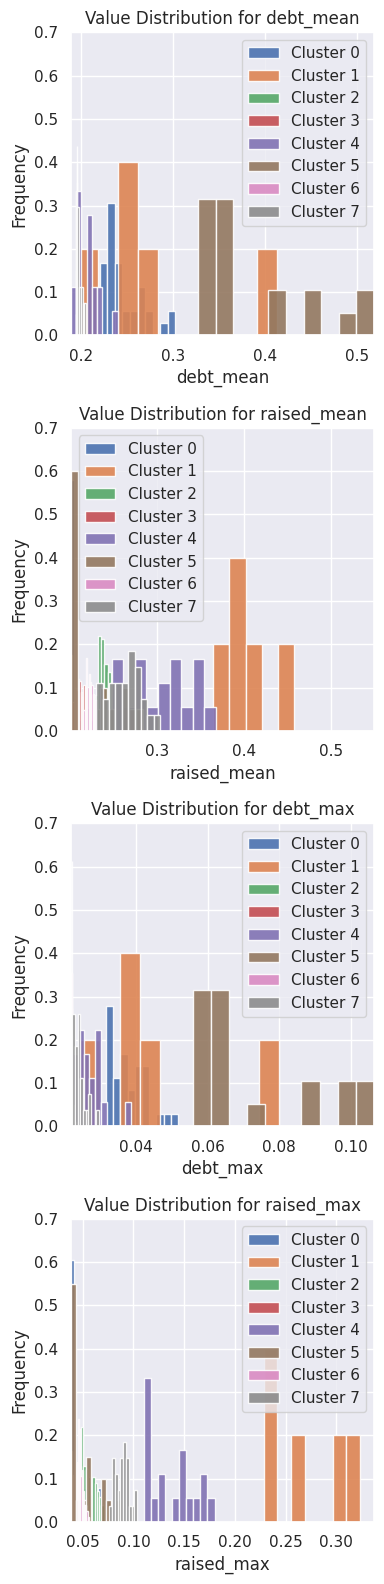

In [90]:
columns_to_plot = ['debt_mean', 'raised_mean', 'debt_max', 'raised_max']
plot_cluster_value_distribution(columns_to_consider, columns_to_plot, X, model.labels_, plot_vertices_number=1000)

#### Experiment 2: fixed clusters.
Goal: interpretable table

Compute unstructured hierarchical clustering...
Elapsed time: 8.08s
Number of points: 10000
Number of clusters: 5
cluster: 0, size: (24,), max bar: 24.99999875000006%
cluster: 1, size: (102,), max bar: 25.55555527160494%
cluster: 2, size: (631,), max bar: 18.694885328580447%
cluster: 3, size: (5,), max bar: 49.99998750000312%
cluster: 4, size: (221,), max bar: 14.572864248377568%
cluster: 0, size: (24,), max bar: 24.99999875000006%
cluster: 1, size: (102,), max bar: 34.37499964192709%
cluster: 2, size: (631,), max bar: 22.70450747461685%
cluster: 3, size: (5,), max bar: 49.99998750000312%
cluster: 4, size: (221,), max bar: 23.333333222222223%


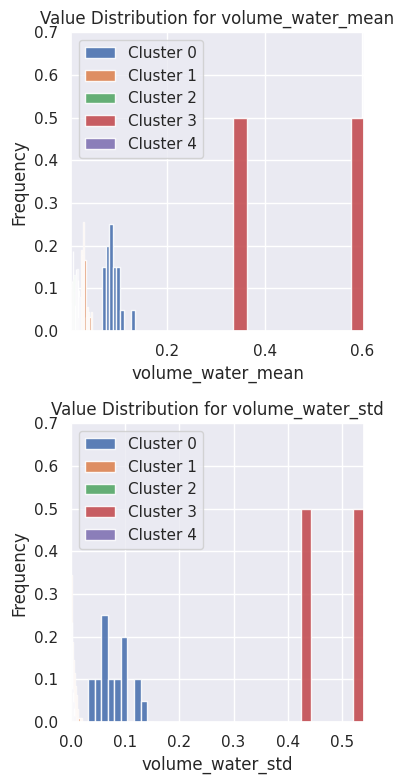

In [41]:
columns_to_consider = [f"{i}_{j}" for i in ['volume_water'] for j in ['mean', 'std']]
X, model_2, _ = run_ward(columns_to_consider, distance_threshold=0.5, n_clusters=None, subset_size = 10000)
columns_to_plot = columns_to_consider
plot_cluster_value_distribution(columns_to_consider, columns_to_plot, X, model_2.labels_, plot_vertices_number=1000)

cluster: 0, size: (22,), max bar: 27.777776234567988%
cluster: 1, size: (101,), max bar: 24.175823910155785%
cluster: 2, size: (632,), max bar: 17.957746447257488%
cluster: 4, size: (224,), max bar: 15.999999919999999%
cluster: 0, size: (22,), max bar: 27.777776234567988%
cluster: 1, size: (101,), max bar: 37.49999960937501%
cluster: 2, size: (632,), max bar: 25.66666662388889%
cluster: 4, size: (224,), max bar: 21.69811310519758%


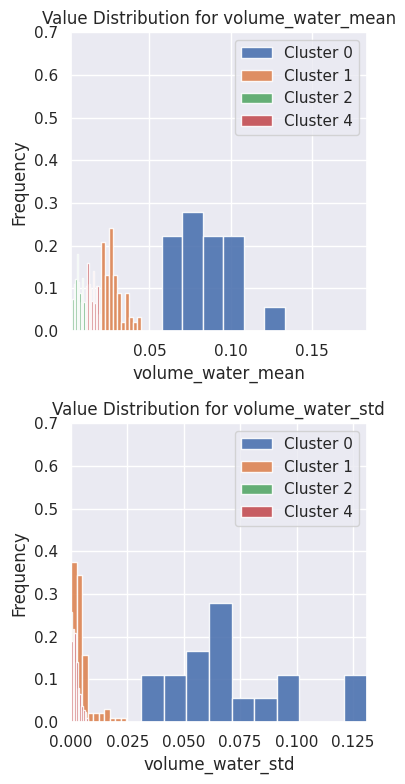

In [48]:
plot_cluster_value_distribution(columns_to_consider, columns_to_plot, X, model_2.labels_, clusters_to_exclude=[3])

Compute unstructured hierarchical clustering...
Elapsed time: 10.11s
Number of points: 10000
Number of clusters: 3
cluster: 0, size: (448,), max bar: 91.76755425722142%
cluster: 1, size: (221,), max bar: 66.51162759762033%
cluster: 2, size: (331,), max bar: 14.28571423825344%
cluster: 0, size: (448,), max bar: 48.7058822383391%
cluster: 1, size: (221,), max bar: 63.31658259639909%
cluster: 2, size: (331,), max bar: 59.803921373189795%
cluster: 0, size: (448,), max bar: 27.88461531758506%
cluster: 1, size: (221,), max bar: 33.165828979066184%
cluster: 2, size: (331,), max bar: 21.548821476266593%
cluster: 0, size: (448,), max bar: 43.29411754519031%
cluster: 1, size: (221,), max bar: 44.723617865710466%
cluster: 2, size: (331,), max bar: 28.619528523166572%


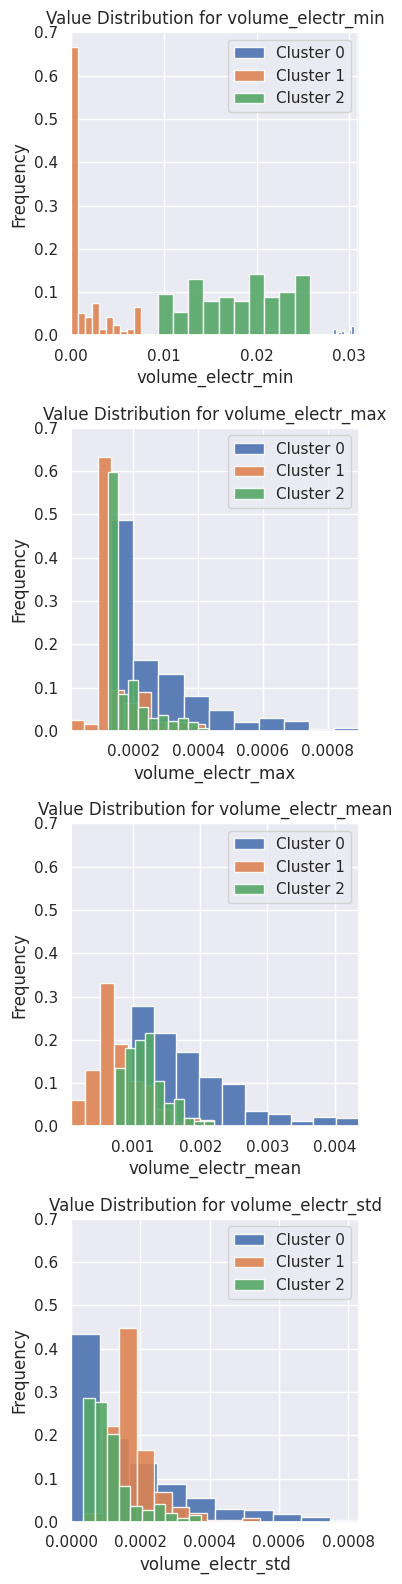

In [49]:
columns_to_consider = [f"{i}_{j}" for i in ['volume_electr'] for j in ['min', 'max', 'mean', 'std']]
X, model_3, _ = run_ward(columns_to_consider, distance_threshold=0.5, n_clusters=None, subset_size = 10000)
columns_to_plot = columns_to_consider
plot_cluster_value_distribution(columns_to_consider, columns_to_plot, X, model_3.labels_, plot_vertices_number=1000)

In [42]:
import pickle

filename = 'agglomerative_model_debt_2_clust.sav'
pickle.dump(model_1, open(filename, 'wb'))

filename = 'agglomerative_model_volume_water.sav'
pickle.dump(model_2, open(filename, 'wb'))

filename = 'agglomerative_model_volume_electr.sav'
pickle.dump(model_3, open(filename, 'wb'))

In [19]:
import pickle

filename = 'models//agglomerative_model_debt_2_clust.sav'
model_1 = pickle.load(open(filename, 'rb'))

filename = 'models//agglomerative_model_volume_water.sav'
model_2 = pickle.load(open(filename, 'rb'))

D:\E\Downloads\Anaconda\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator AgglomerativeClustering from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [53]:
random_indexes = random.sample(range(len(user_features)), 10000)

is_low_paying = (user_features['raised_mean'] < user_features['raised_mean'].mean()).iloc[random_indexes]
is_water_high_consumer = (user_features['volume_water_mean'] > user_features['volume_water_mean'].mean()).iloc[random_indexes]
electric_low_consumer = (user_features['volume_electr_mean'] < user_features['volume_electr_mean'].mean()).iloc[random_indexes]
electric_low_consumer = np.array(list(electric_low_consumer))

X = user_features.iloc[random_indexes]

In [54]:
data = {
    'Payment': ['Low Payment', 'Low Payment', 'Low Payment', 'Low Payment', 'High Payment', 'High Payment', 'High Payment', 'High Payment'],
    'Water Consumption': ['Low Water Consumption', 'Low Water Consumption', 'High Water Consumption', 'High Water Consumption', 'Low Water Consumption', 'Low Water Consumption', 'High Water Consumption', 'High Water Consumption',],
    'Electricity Consumption': ['Low Electricity Consumption', 'High Electricity Consumption', 'Low Electricity Consumption', 'High Electricity Consumption', 'Low Electricity Consumption', 'High Electricity Consumption', 'Low Electricity Consumption', 'High Electricity Consumption'],
    'Percentage': [0,0,0,0,0,0,0,0]  # Initialize 'Percentage' as an empty list
}
table = pd.DataFrame(data, columns=['Payment', 'Water Consumption', 'Electricity Consumption', 'Percentage'])

# Calculate percentages for each category
for i, payment in enumerate(['Low', 'High']):
    for j, water in enumerate(['Low', 'High']):
        for k, elec in enumerate(['Low', 'High']):
            filtered_users = X[
                (is_low_paying == (payment == 'Low')) & 
                (is_water_high_consumer == (water == 'High')) &
                np.where(elec == 'Low', electric_low_consumer, ~electric_low_consumer)
            ]

            percentage = len(filtered_users) / len(X) * 100
            table.iloc[i * 4 + j * 2 + k, 3] = f"{percentage:.1f}%"  # Update Percentage column

# Print the table beautifully
print(table.to_string(index=False))

     Payment      Water Consumption      Electricity Consumption Percentage
 Low Payment  Low Water Consumption  Low Electricity Consumption      44.1%
 Low Payment  Low Water Consumption High Electricity Consumption       6.7%
 Low Payment High Water Consumption  Low Electricity Consumption       8.1%
 Low Payment High Water Consumption High Electricity Consumption       2.4%
High Payment  Low Water Consumption  Low Electricity Consumption       5.2%
High Payment  Low Water Consumption High Electricity Consumption       9.6%
High Payment High Water Consumption  Low Electricity Consumption      10.3%
High Payment High Water Consumption High Electricity Consumption      13.7%


In [48]:
data = {
    'Payment': ['Low Payment', 'Low Payment', 'Low Payment', 'Low Payment', 'High Payment', 'High Payment', 'High Payment', 'High Payment'],
    'Water Consumption': ['Low Water Consumption', 'Low Water Consumption', 'High Water Consumption', 'High Water Consumption', 'Low Water Consumption', 'Low Water Consumption', 'High Water Consumption', 'High Water Consumption',],
    'Electricity Consumption': ['Low Electricity Consumption', 'High Electricity Consumption', 'Low Electricity Consumption', 'High Electricity Consumption', 'Low Electricity Consumption', 'High Electricity Consumption', 'Low Electricity Consumption', 'High Electricity Consumption'],
    'Percentage': [0,0,0,0,0,0,0,0]  # Initialize 'Percentage' as an empty list
}
table = pd.DataFrame(data, columns=['Payment', 'Water Consumption', 'Electricity Consumption', 'Percentage'])

# Calculate percentages for each category
for i, payment in enumerate(['Low', 'High']):
    for j, water in enumerate(['Low', 'High']):
        for k, elec in enumerate(['Low', 'High']):
            filtered_users = X[
                (is_low_paying == (payment == 'Low')) & 
                (is_water_high_consumer == (water == 'High')) &
                np.where(elec == 'Low', electric_low_consumer, ~electric_low_consumer)
            ]

            percentage = len(filtered_users) / len(X) * 100
            table.iloc[i * 4 + j * 2 + k, 3] = f"{percentage:.1f}%"  # Update Percentage column

# Print the table beautifully
print(table.to_string(index=False))

     Payment      Water Consumption      Electricity Consumption Percentage
 Low Payment  Low Water Consumption  Low Electricity Consumption      36.0%
 Low Payment  Low Water Consumption High Electricity Consumption      35.0%
 Low Payment High Water Consumption  Low Electricity Consumption      11.6%
 Low Payment High Water Consumption High Electricity Consumption      11.4%
High Payment  Low Water Consumption  Low Electricity Consumption       2.2%
High Payment  Low Water Consumption High Electricity Consumption       2.4%
High Payment High Water Consumption  Low Electricity Consumption       0.6%
High Payment High Water Consumption High Electricity Consumption       0.8%


## My special idea
- write custom BIRCH
- control BIRCH so that on first few layers it devides users by our handwritten rules. These rules would be first based on the debt and raised. Then based on water.
- Goal: make a dumb tree that can be visualized and well interpretable

### Birch custom

In [ ]:
class CFVector:
    def __init__(self, n=0, LS=None, SS=None):
        self.n = n
        self.LS = np.zeros(2) if LS is None else LS
        self.SS = np.zeros(2) if SS is None else SS

